# 言語処理100本ノック 2020 第５章

Reference: https://nlp100.github.io/ja/ch05.html

In [3]:
! cabocha -f1 neko.txt > neko.txt.cabocha

In [126]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
from graphviz import Digraph

## 40. 係り受け解析結果の読み込み（形態素）

形態素を表すクラスMorphを実装せよ．このクラスは表層形（surface），基本形（base），品詞（pos），品詞細分類1（pos1）をメンバ変数に持つこととする．さらに，CaboChaの解析結果（neko.txt.cabocha）を読み込み，各文をMorphオブジェクトのリストとして表現し，3文目の形態素列を表示せよ．

In [53]:
class Morph():
    def __init__(self, surface, base, pos, pos1):
        self.surface = surface
        self.base = base
        self.pos = pos
        self.pos1 = pos1
    def __str__(self):
        return(self.surface)
    def summary(self):
        return("{}\t{}\t{}\t{}".format(self.surface, self.base, self.pos, self.pos1))

In [54]:
with open("neko.txt.cabocha", "r", encoding="utf-8") as fi:
    lines = fi.readlines()
    s = [] # sentence
    s_s = [] # list of sentence
    for line in lines:
        if re.match("^EOS", line):
            if len(s) != 0: s_s.append(s)
            s = []
        elif not (re.match("^\u3000", line) or re.match("^\*", line)):
            word, info = line.strip("\n").split("\t")
            info_list = info.split(",")
            pos, pos1 = info_list[:2]
            if(len(info_list) > 6): base = info_list[6]
            else: base = ""
            s.append(Morph(word, base, pos, pos1))

In [55]:
for m in s_s[2]: print(m.summary())

名前	名前	名詞	一般
は	は	助詞	係助詞
まだ	まだ	副詞	助詞類接続
無い	無い	形容詞	自立
。	。	記号	句点


## 41. 係り受け解析結果の読み込み（文節・係り受け）

40に加えて，文節を表すクラスChunkを実装せよ．このクラスは形態素（Morphオブジェクト）のリスト（morphs），係り先文節インデックス番号（dst），係り元文節インデックス番号のリスト（srcs）をメンバ変数に持つこととする．さらに，入力テキストのCaboChaの解析結果を読み込み，１文をChunkオブジェクトのリストとして表現し，8文目の文節の文字列と係り先を表示せよ．第5章の残りの問題では，ここで作ったプログラムを活用せよ．

In [165]:
class Chunk():
    def __init__(self, morphs, id, dst, srcs):
        self.morphs = morphs
        self.id = int(id)
        self.dst = int(dst)
        self.srcs = srcs
    def __str__(self):
        return "".join([str(morph) for morph in self.morphs])
    def summary(self):
        words = " ".join([str(morph) for morph in self.morphs])
        str_src = "".join([str(src) for src in self.srcs])
        return "{}\t{}\t{}\t".format(self.id, words, self.dst, str_src)

In [166]:
with open("neko.txt.cabocha", "r", encoding="utf-8") as fi:
    lines = fi.readlines()
    morphs = [] # list of morphs
    s = [] # sentence
    s_s = [] # list of sentence
    for line in lines:
        if re.match("^EOS", line):
            if len(s) != 0:
                s.append(Chunk(morphs, id, dst, []))
                s_s.append(s)
            s = []
            morphs = []
        elif re.match("^\*", line):
            if len(morphs) != 0:
                s.append(Chunk(morphs, id, dst, []))
            _, id, dst, _, _ = line.strip("\n").split(" ")
            dst = dst.strip("D")
            morphs = []
        else:
            word, info = line.strip("\n").split("\t")
            info_list = info.split(",")
            pos, pos1 = info_list[:2]
            if(len(info_list) > 6): base = info_list[6]
            else: base = ""
            morphs.append(Morph(word, base, pos, pos1))

In [167]:
for s in s_s:
    for c in s:
        if c.dst > 0: s[c.dst].srcs.append(c.id)

In [168]:
for c in s_s[7]:
    print(c.summary())

0	しかし	9	
1	その	2	
2	当時 は	5	
3	何 という	4	
4	考 も	5	
5	なかっ た から	9	
6	別段	7	
7	恐し	9	
8	いとも	9	
9	思わ なかっ た 。	-1	


## 42. 係り元と係り先の文節の表示

係り元の文節と係り先の文節のテキストをタブ区切り形式ですべて抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [169]:
s = s_s[7]
for c in s:
    start = str(c).strip("。、")
    if c.dst > 0: dest = str(s[c.dst]).strip("。、")
    else: dest = ""
    print("{}\t{}".format(start, dest))

しかし	思わなかった
その	当時は
当時は	なかったから
何という	考も
考も	なかったから
なかったから	思わなかった
別段	恐し
恐し	思わなかった
いとも	思わなかった
思わなかった	


## 43. 名詞を含む文節が動詞を含む文節に係るものを抽出

名詞を含む文節が，動詞を含む文節に係るとき，これらをタブ区切り形式で抽出せよ．ただし，句読点などの記号は出力しないようにせよ．

In [170]:
s = s_s[2]
for c_start in s:
    if c_start.dst > 0: c_dest = s[c_start.dst]
    else: continue
    if ("名詞" in [m.pos for m in c_start.morphs]) and ("動詞" in [m.pos for m in c_dest.morphs]):
        start = str(c_start).strip("。、")
        dest = str(c_dest).strip("。、")
        print("{}\t{}".format(start, dest))

　どこで	生れたか
見当が	つかぬ


## 44. 係り受け木の可視化

与えられた文の係り受け木を有向グラフとして可視化せよ．可視化には，係り受け木をDOT言語に変換し，Graphvizを用いるとよい．また，Pythonから有向グラフを直接的に可視化するには，pydotを使うとよい．

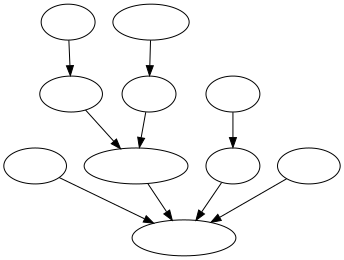

In [171]:
s = s_s[7]
dg = Digraph() # graph

for c in s: 
    dg.node(str(c).strip("。、"))

for c in s:
    if c.dst > 0: 
        dg.edge(str(c).strip("。、"), str(s[c.dst]).strip("。、"))
dg

## 45. 動詞の格パターンの抽出

今回用いている文章をコーパスと見なし，日本語の述語が取りうる格を調査したい． 動詞を述語，動詞に係っている文節の助詞を格と考え，述語と格をタブ区切り形式で出力せよ． ただし，出力は以下の仕様を満たすようにせよ．

* 動詞を含む文節において，最左の動詞の基本形を述語とする
* 述語に係る助詞を格とする
* 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる

「吾輩はここで始めて人間というものを見た」という例文（neko.txt.cabochaの8文目）を考える． この文は「始める」と「見る」の２つの動詞を含み，「始める」に係る文節は「ここで」，「見る」に係る文節は「吾輩は」と「ものを」と解析された場合は，次のような出力になるはずである．

    始める  で
    見る    は を

このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．

* コーパス中で頻出する述語と格パターンの組み合わせ
* 「する」「見る」「与える」という動詞の格パターン（コーパス中で出現頻度の高い順に並べよ）


In [237]:
results = []
for i, s in enumerate(s_s):
    for c in s:
        verb = ""
        pps = [] # 助詞
        for m in c.morphs:
            if m.pos == "動詞":
                verb = m.base
                break
        if verb == "": continue
        #
        for src in c.srcs:
            for m in s[src].morphs[::-1]:
                if m.pos == "助詞":
                    pps.append(m.base)
                    break
        if len(pps) > 0: results.append("{}\t{}".format(verb, " ".join(pps)))

In [238]:
for i in results[:10]: print(i)

生れる	で
つく	か が
泣く	で
する	て は
始める	で
見る	は を
聞く	で
捕える	を
煮る	て
食う	て


In [239]:
tmp = np.unique(results, return_counts=True)
idx = np.argsort(tmp[1])[::-1][:10]
tmp[0][idx], tmp[1][idx]

(array(['云う\tと', 'する\tを', '思う\tと', 'ある\tが', 'なる\tに', 'する\tに', '見る\tて',
        'する\tと', 'する\tが', '見る\tを'], dtype='<U22'),
 array([704, 452, 333, 202, 199, 188, 175, 159, 117,  98]))

## 46. 動詞の格フレーム情報の抽出

45のプログラムを改変し，述語と格パターンに続けて項（述語に係っている文節そのもの）をタブ区切り形式で出力せよ．45の仕様に加えて，以下の仕様を満たすようにせよ．

* 項は述語に係っている文節の単語列とする（末尾の助詞を取り除く必要はない）
* 述語に係る文節が複数あるときは，助詞と同一の基準・順序でスペース区切りで並べる

「吾輩はここで始めて人間というものを見た」という例文（neko.txt.cabochaの8文目）を考える． この文は「始める」と「見る」の２つの動詞を含み，「始める」に係る文節は「ここで」，「見る」に係る文節は「吾輩は」と「ものを」と解析された場合は，次のような出力になるはずである．

    始める  で      ここで
    見る    は を   吾輩は ものを

In [255]:
results = []
for i, s in enumerate(s_s):
    for c in s:
        verb = ""
        pps = [] # 助詞
        chunks = [] # 文節
        for m in c.morphs:
            if m.pos == "動詞":
                verb = m.base
                break
        if verb == "": continue
        #
        for src in c.srcs:
            for m in s[src].morphs[::-1]:
                if m.pos == "助詞":
                    pps.append(m.base)
                    chunks.append(str(s[src]).strip("、。"))
                    break
        if len(pps) > 0: results.append("{}\t{}\t{}".format(verb, " ".join(pps), " ".join(chunks)))

In [256]:
for i in results[:10]: print(i)

生れる	で	　どこで
つく	か が	生れたか 見当が
泣く	で	所で
する	て は	泣いて いた事だけは
始める	で	ここで
見る	は を	吾輩は ものを
聞く	で	あとで
捕える	を	我々を
煮る	て	捕えて
食う	て	煮て


## 47. 機能動詞構文のマイニング

動詞のヲ格にサ変接続名詞が入っている場合のみに着目したい．46のプログラムを以下の仕様を満たすように改変せよ．

* 「サ変接続名詞+を（助詞）」で構成される文節が動詞に係る場合のみを対象とする
* 述語は「サ変接続名詞+を+動詞の基本形」とし，文節中に複数の動詞があるときは，最左の動詞を用いる
* 述語に係る助詞（文節）が複数あるときは，すべての助詞をスペース区切りで辞書順に並べる
* 述語に係る文節が複数ある場合は，すべての項をスペース区切りで並べる（助詞の並び順と揃えよ）

例えば「別段くるにも及ばんさと、主人は手紙に返事をする。」という文から，以下の出力が得られるはずである．

    返事をする      と に は        及ばんさと 手紙に 主人は

このプログラムの出力をファイルに保存し，以下の事項をUNIXコマンドを用いて確認せよ．

* コーパス中で頻出する述語（サ変接続名詞+を+動詞）
* コーパス中で頻出する述語と助詞パターン

In [257]:
results = []
for i, s in enumerate(s_s):
    for c in s:
        if len(c.morphs) != 2: continue
        if (c.morphs[0].pos1 != "サ変接続") or (c.morphs[1].base != "を"): continue
        #
        verb = ""
        for m in s[c.dst].morphs:
            if m.pos == "動詞":
                verb = m.base
                break
        if verb == "": continue
        verb = str(c) + verb
        #
        pps = [] # 助詞
        chunks = [] # 文節
        for src in s[c.dst].srcs:
            if s[src] == c: continue
            for m in s[src].morphs[::-1]:
                if m.pos == "助詞":
                    pps.append(m.base)
                    chunks.append(str(s[src]).strip("、。"))
                    break
        if len(pps) > 0: results.append("{}\t{}\t{}".format(verb, " ".join(pps), " ".join(chunks)))

In [258]:
for i in results[:10]: print(i)

決心をする	と	こうと
返報をする	んで	偸んで
昼寝をする	が	彼が
迫害を加える	て	追い廻して
投書をする	て へ	やって ほととぎすへ
話をする	に	時に
昼寝をする	て	出て
欠伸をする	から て て	なったから して 押し出して
報道をする	に	耳に
御馳走を食う	と	見ると


## 48. 名詞から根へのパスの抽出

文中のすべての名詞を含む文節に対し，その文節から構文木の根に至るパスを抽出せよ． ただし，構文木上のパスは以下の仕様を満たすものとする．

* 各文節は（表層形の）形態素列で表現する
* パスの開始文節から終了文節に至るまで，各文節の表現を” -> “で連結する

「吾輩はここで始めて人間というものを見た」という文（neko.txt.cabochaの5文目）から，次のような出力が得られるはずである．

    吾輩は -> 見た
    ここで -> 始めて -> 人間という -> ものを -> 見た
    人間という -> ものを -> 見た
    ものを -> 見た


In [266]:
def get_path(idx, s):
    if s[idx].dst > 0:
        return [str(s[idx]).strip("、。")] + get_path(s[idx].dst, s)
    else:
        return [str(s[idx]).strip("、。")]

In [287]:
s = s_s[4]
results = []
for i, c in enumerate(s):
    if not "名詞" in [m.pos for m in c.morphs]: continue
    results.append(" -> ".join(get_path(i, s)))

In [288]:
results

['吾輩は -> 見た',
 'ここで -> 始めて -> 人間という -> ものを -> 見た',
 '人間という -> ものを -> 見た',
 'ものを -> 見た']

## 49. 名詞間の係り受けパスの抽出

文中のすべての名詞句のペアを結ぶ最短係り受けパスを抽出せよ．ただし，名詞句ペアの文節番号がiとj（i<j）のとき，係り受けパスは以下の仕様を満たすものとする．

* 問題48と同様に，パスは開始文節から終了文節に至るまでの各文節の表現（表層形の形態素列）を” -> “で連結して表現する
* 文節iとjに含まれる名詞句はそれぞれ，XとYに置換する

また，係り受けパスの形状は，以下の2通りが考えられる．

* 文節iから構文木の根に至る経路上に文節jが存在する場合: 文節iから文節jのパスを表示
* 上記以外で，文節iと文節jから構文木の根に至る経路上で共通の文節kで交わる場合: 文節iから文節kに至る直前のパスと文節jから文節kに至る直前までのパス，文節kの内容を” | “で連結して表示

例えば，「吾輩はここで始めて人間というものを見た。」という文（neko.txt.cabochaの8文目）から，次のような出力が得られるはずである．

    Xは | Yで -> 始めて -> 人間という -> ものを | 見た
    Xは | Yという -> ものを | 見た
    Xは | Yを | 見た
    Xで -> 始めて -> Y
    Xで -> 始めて -> 人間という -> Y
    Xという -> Y
